<a href="https://colab.research.google.com/github/Deep-Learning-IGP-TUBS-SoSe2022/2022-Group03/blob/main/Assignments/02-CNN_UCM/VanillaCNN-UCM_LeNet-like.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Course**: Deep Learning | Assignment03: Transfer Learning on EuroSAT

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/) 

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp) 


**Group:** 03

Students: Fabian Linkerhägner | Yu-Chuan Cheng

#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------

# 1) Preparations

### 1.1) Mounting google drive

In [ ]:
#@title
# mount google drive on google colab
print("[Info] Mounting google drive...\n")
from google.colab import drive
drive.mount('/content/drive')
print("\n[Info] Google drive mounted.")

[Info] Mounting google drive...

Mounted at /content/drive

[Info] Google drive mounted.


### 1.2) Import of required packages


In [ ]:
# source : https://github.com/raoofnaushad/Land-Cover-Classification-using-Sentinel-2-Dataset/blob/master/Land_Cover_Classification_using_Sentinel_2_Satellite_Imagery_and_Deep_Learning.ipynb
# Author: raoofaccubits 

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode



import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torch.nn.functional as F
print(torch.__version__)
writer = SummaryWriter()

1.12.0+cu113


#Config

In [ ]:
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/Deep learning task'
BASE_PATH = os.path.join(ROOT_PATH, 'Image_Dataset')
DATA_PATH = os.path.join(ROOT_PATH, 'Dataset')
FULL_DATA_DF = os.path.join(ROOT_PATH, 'FULL_DATA.csv')

if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.1

#Utils

In [ ]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
## Example for decoding and encoding
print(encode_label('Forest'), decode_target(2))
print(decode_target(2, text_labels=True))

1 HerbaceousVegetation
HerbaceousVegetation


#Pre-Processing data folders to train and test

In [ ]:
from os import walk
i = 0
for (dirpath, dirname, filename) in walk(BASE_PATH):
  print("Directory Path: ", dirpath)
  print("Directory Name: ", dirname)
  print("Filename : ", filename)
  print("----------------------"*10)
  i += 1
  if i > 3:
    break

Directory Path:  /content/drive/MyDrive/Colab Notebooks/Deep learning task/Image_Dataset
Directory Name:  ['River', 'AnnualCrop', 'HerbaceousVegetation', 'Industrial', 'Residential', 'Highway', 'Pasture', 'Forest', 'SeaLake', 'PermanentCrop']
Filename :  []
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Directory Path:  /content/drive/MyDrive/Colab Notebooks/Deep learning task/Image_Dataset/River
Directory Name:  []
Filename :  ['River_423.jpg', 'River_851.jpg', 'River_384.jpg', 'River_1456.jpg', 'River_1824.jpg', 'River_2122.jpg', 'River_1037.jpg', 'River_1790.jpg', 'River_734.jpg', 'River_1741.jpg', 'River_1487.jpg', 'River_1320.jpg', 'River_880.jpg', 'River_355.jpg', 'River_2235.jpg', 'River_1509.jpg', 'River_1168.jpg', 'River_1823.jpg', 'River_1451.jpg', 'River_383.jpg', 'River_856.jpg', 'River_424.jpg', 'River

In [ ]:
from os import walk

i = 0
DATA_DF = pd.DataFrame(columns = ['image_id', 'label']) 

for (dirpath, dirname, filename) in walk(BASE_PATH):
  for each_file in filename:
    DATA_DF.loc[i] = [each_file, dirpath.split('/')[-1]]
    i += 1
  # break
DATA_DF.to_csv(FULL_DATA_DF, index=False)
DATA_DF.head()

,image_id,label
0,River_423.jpg,River
1,River_851.jpg,River
2,River_384.jpg,River
3,River_1456.jpg,River
4,River_1824.jpg,River


#Processing data folders to train and test

In [ ]:
DATA_DF = pd.read_csv(FULL_DATA_DF)
DATA_DF = DATA_DF.sample(frac = 1, random_state=48) 
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*VALID_SIZE)]
VALID_DF = DATA_DF[-int(len(DATA_DF)*VALID_SIZE) :]

In [ ]:
TRAIN_DF.reset_index(inplace = True) 
TRAIN_DF.head()

,index,image_id,label
0,19127,Forest_426.jpg,Forest
1,3197,AnnualCrop_1987.jpg,AnnualCrop
2,24557,PermanentCrop_396.jpg,PermanentCrop
3,17042,Pasture_1406.jpg,Pasture
4,3697,AnnualCrop_2353.jpg,AnnualCrop


In [ ]:
VALID_DF.reset_index(inplace = True) 
VALID_DF.head()

,index,image_id,label
0,21985,SeaLake_2419.jpg,SeaLake
1,25621,PermanentCrop_2484.jpg,PermanentCrop
2,21573,SeaLake_1106.jpg,SeaLake
3,25070,PermanentCrop_1943.jpg,PermanentCrop
4,13947,Residential_2212.jpg,Residential


In [ ]:
TRAIN_DF.size, VALID_DF.size

(72900, 8100)

## 2) Load the dataset

In [ ]:
class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img = Image.open(os.path.join(self.train_dir, img_id.split('.')[0].split('_')[0], img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

24300 2700


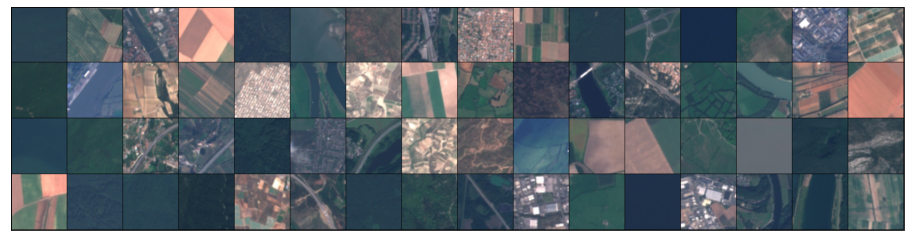

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transform = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

train_ds = EuroSAT(TRAIN_DF, BASE_PATH, data_transform)
valid_ds = EuroSAT(VALID_DF, BASE_PATH, data_transform)
print(len(train_ds), len(valid_ds))

batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [ ]:
model = LULC_Model()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [ ]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:  
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
try_batch(train_dl)

torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.4091, -2.3645, -2.4202, -2.2357, -2.3109, -1.9179, -2.2256, -2.5630,
        -2.4272, -2.2944], grad_fn=<SelectBackward0>)


#Training and Evaluation

In [ ]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)

            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    writer.add_scalar("Loss/Val", valid_loss_min, epoch)
    writer.add_scalar("Acc/Val", valid_acc_max, epoch)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

#Initializing Device also Loading Data and Model to device

In [ ]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(LULC_Model(), device)
## lets try passing a batch to model again
try_batch(train_dl)

True


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.4563, -2.3123, -2.0429, -2.2012, -2.4320, -2.2842, -2.3167, -2.2813,
        -2.6569, -2.1693], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
torch.cuda.empty_cache()

#Training

In [ ]:
## Hyper Parameters
max_epochs_stop = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 10
opt_func = torch.optim.Adam

In [ ]:
!pip install torchinfo
import torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Freezing except last layer
model.freeze()

In [ ]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext autotime

time: 122 µs (started: 2022-07-13 12:24:02 +00:00)


In [ ]:
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9473, learning_rate: 0.0001, train_loss: 0.1867, val_loss: 0.1201, val_acc: 0.9648


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9673, learning_rate: 0.0001, train_loss: 0.1072, val_loss: 0.1174, val_acc: 0.9698


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9724, learning_rate: 0.0001, train_loss: 0.0872, val_loss: 0.0764, val_acc: 0.9755


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9746, learning_rate: 0.0001, train_loss: 0.0838, val_loss: 0.0787, val_acc: 0.9749


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9768, learning_rate: 0.0001, train_loss: 0.0788, val_loss: 0.1214, val_acc: 0.9603


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9790, learning_rate: 0.0001, train_loss: 0.0702, val_loss: 0.0715, val_acc: 0.9792


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9797, learning_rate: 0.0001, train_loss: 0.0679, val_loss: 0.0576, val_acc: 0.9822


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9808, learning_rate: 0.0001, train_loss: 0.0625, val_loss: 0.0829, val_acc: 0.9764


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9840, learning_rate: 0.0001, train_loss: 0.0526, val_loss: 0.2306, val_acc: 0.9333


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9820, learning_rate: 0.0001, train_loss: 0.0594, val_loss: 0.0918, val_acc: 0.9752
VAL LOSS MIN 0.05758615955710411
VAL ACC MAX 0.9821947813034058
time: 1h 51min 21s (started: 2022-07-13 12:24:09 +00:00)


In [ ]:
writer.close()

time: 1.79 ms (started: 2022-07-13 14:15:31 +00:00)


#Report

In [ ]:
pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.63 s (started: 2022-07-13 14:15:31 +00:00)


##Training Reports

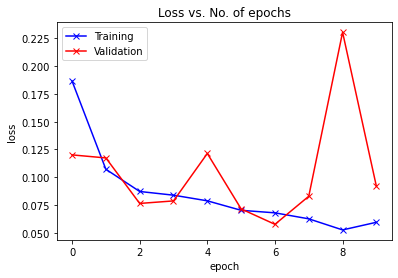

time: 978 ms (started: 2022-07-13 14:16:23 +00:00)


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

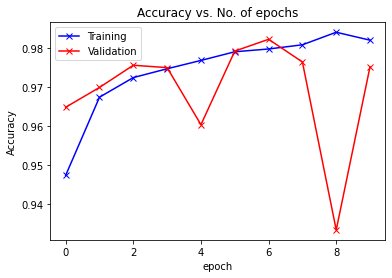

time: 149 ms (started: 2022-07-13 14:16:29 +00:00)


In [ ]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

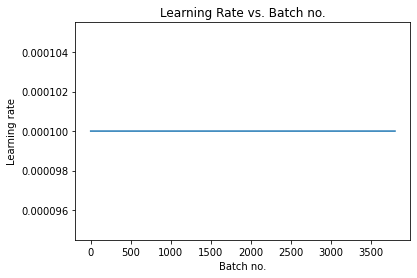

time: 165 ms (started: 2022-07-13 14:16:31 +00:00)


In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

##Prediction Reports

In [ ]:
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

### Predict Single Images
def predict_single(image):
    show_sample(image)
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)

time: 4.04 ms (started: 2022-07-13 14:16:34 +00:00)


'Highway'

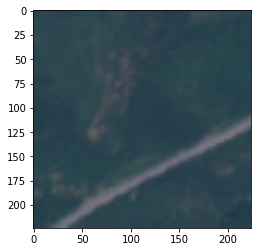

time: 743 ms (started: 2022-07-13 14:16:39 +00:00)


In [ ]:
predict_single(valid_ds[40][0])

'Highway'

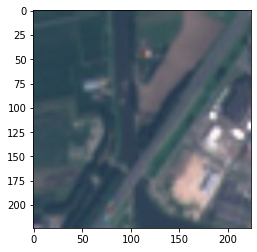

time: 178 ms (started: 2022-07-13 14:16:40 +00:00)


In [ ]:
predict_single(valid_ds[90][0])

#Evalutaion on whoel dataset

In [ ]:
batch_size =1
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

time: 5.04 ms (started: 2022-07-13 14:16:42 +00:00)


In [ ]:
## Accuracy Evaluation
def final_accuracy(predictions, labels):
  predictions = to_device(predictions, device)
  labels = to_device(labels, device)
  ## Total Accuracy
  total = 0
  for i in range(len(predictions)):
    if predictions[i] == labels[i]:
      total += 1
  acc = total/len(predictions)
  print(acc)

time: 2.9 ms (started: 2022-07-13 14:16:45 +00:00)


In [ ]:
full_ds = EuroSAT(DATA_DF, BASE_PATH, data_transform)
full_dl = DataLoader(full_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
device = get_device()
## Loading data to devide
full_dl = DeviceDataLoader(full_dl, device)

True
time: 4.31 ms (started: 2022-07-13 14:16:47 +00:00)


In [ ]:
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

  0%|          | 0/27000 [00:00<?, ?it/s]

0.9887777777777778


array([[2991,    1,    0,    9,    0,   22,   12,    0,   27,    0],
       [   0, 2997,    3,    1,    0,    0,    0,    0,    9,    0],
       [   0,    0, 2957,    0,    0,   16,    5,    2,    4,    0],
       [   0,    0,    0, 2483,    5,    0,    0,    1,   10,    0],
       [   0,    0,    0,    0, 2412,    0,    0,    2,    1,    0],
       [   1,    1,    3,    1,    0, 1950,    1,    0,    0,    0],
       [   5,    0,   33,    3,   78,    4, 2482,    0,   13,    0],
       [   0,    0,    0,    0,    3,    0,    0, 2995,    0,    0],
       [   0,    0,    0,    2,    2,    6,    0,    0, 2433,    3],
       [   3,    1,    4,    1,    0,    2,    0,    0,    3, 2997]])

time: 6min 43s (started: 2022-07-13 14:16:49 +00:00)


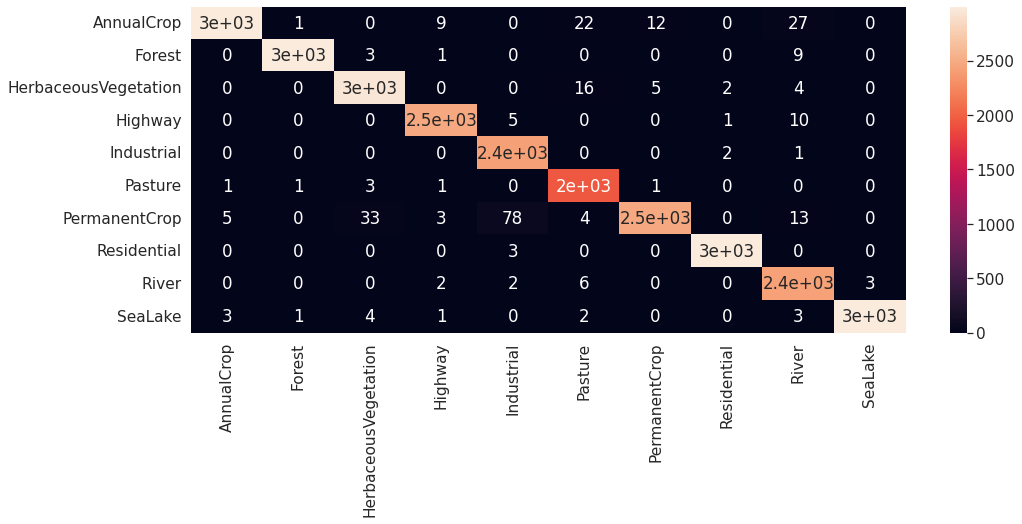

time: 865 ms (started: 2022-07-13 14:23:32 +00:00)


In [ ]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)

In [ ]:
## Evaluation with best validation accuracy model
model = LULC_Model()
model.load_state_dict(torch.load("/content/lulc_max_acc.pth"))
model.eval()
model = to_device(model, device)
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/27000 [00:00<?, ?it/s]

0.9928148148148148


array([[2958,    0,    0,    0,    0,    3,    3,    0,    2,    3],
       [   0, 2998,    2,    0,    0,    2,    0,    0,    0,    0],
       [   4,    1, 2978,    2,    0,    4,   48,    0,    0,    0],
       [   0,    0,    0, 2477,    0,    1,    0,    0,    8,    0],
       [   0,    0,    0,    5, 2499,    0,    0,    6,    1,    0],
       [   1,    0,    7,    0,    0, 1978,    2,    0,    0,    0],
       [  20,    0,    2,    1,    0,    1, 2447,    0,    0,    0],
       [   0,    0,    7,    1,    1,    0,    0, 2994,    0,    0],
       [   8,    0,    0,   14,    0,    8,    0,    0, 2480,    0],
       [   9,    1,    4,    0,    0,    3,    0,    0,    9, 2997]])

time: 6min 43s (started: 2022-07-13 14:23:33 +00:00)


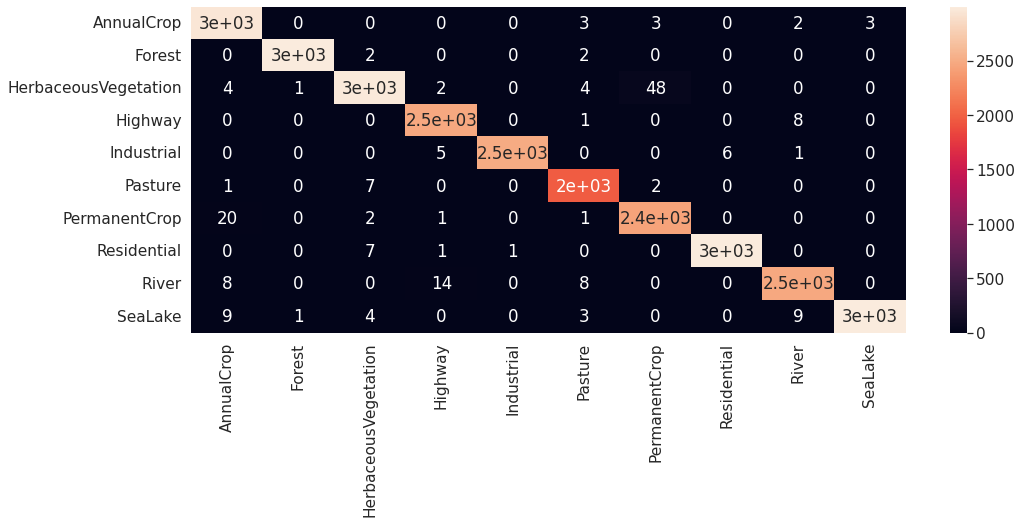

time: 639 ms (started: 2022-07-13 14:30:16 +00:00)


In [ ]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)

In [ ]:
!tensorboard --logdir=runs


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
!pip install tensorboard --upgrade

In [ ]:
!tensorboard dev upload --logdir runs \
--name "Transfer Learning" \
--description "The Acc and Loss in each epoch"